<cell_type>markdown</cell_type># Candidate Generation: Two-Tower Model Exploration

**Phase 1: Exploration**

This notebook explores and prototypes the Two-Tower candidate generation model:

1. **Data Preparation**: Convert explicit ratings to implicit feedback
2. **ID Mappings**: Build bijective mappings for users and items
3. **Model Definition**: Implement Tower and TwoTowerModel
4. **Training Loop**: Train with in-batch softmax loss (1023 negatives per sample!)
5. **Evaluation**: Compute Recall@K metrics
6. **FAISS Index**: Build and test ANN retrieval

**Key insight**: We use **in-batch negatives** instead of explicit negative sampling.
This is industry standard (YouTube, Google, Spotify) and prevents overfitting to static negatives.

**Goal**: Build intuition and validate approach before productionizing.

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, List, Set, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Data and Convert to Implicit Feedback

For candidate generation, we convert explicit ratings to implicit feedback:
- **Positive**: Ratings >= 4 (user liked the item)
- **Negative**: Items the user hasn't interacted with

**Why threshold at 4?**
- Ratings 1-3 may indicate negative sentiment
- We want to retrieve items the user will actually like
- Cleaner training signal

In [5]:
# Load the time-based splits
DATA_DIR = Path('../data/splits')

train_ratings = pd.read_parquet(DATA_DIR / 'train_ratings.parquet')
val_ratings = pd.read_parquet(DATA_DIR / 'val_ratings.parquet')
test_ratings = pd.read_parquet(DATA_DIR / 'test_ratings.parquet')

print(f"Train ratings: {len(train_ratings):,}")
print(f"Val ratings: {len(val_ratings):,}")
print(f"Test ratings: {len(test_ratings):,}")

Train ratings: 800,167
Val ratings: 23,636
Test ratings: 80,298


In [6]:
# Define positive threshold
POSITIVE_THRESHOLD = 4

# Filter to positive interactions only
train_positive = train_ratings[train_ratings['rating'] >= POSITIVE_THRESHOLD].copy()
val_positive = val_ratings[val_ratings['rating'] >= POSITIVE_THRESHOLD].copy()
test_positive = test_ratings[test_ratings['rating'] >= POSITIVE_THRESHOLD].copy()

print(f"Train positive: {len(train_positive):,} ({len(train_positive)/len(train_ratings)*100:.1f}%)")
print(f"Val positive: {len(val_positive):,} ({len(val_positive)/len(val_ratings)*100:.1f}%)")
print(f"Test positive: {len(test_positive):,} ({len(test_positive)/len(test_ratings)*100:.1f}%)")

Train positive: 463,020 (57.9%)
Val positive: 12,528 (53.0%)
Test positive: 43,349 (54.0%)


Positive interactions per user (train):
count    5396.000000
mean       85.808006
std        93.682734
min         1.000000
25%        26.000000
50%        54.000000
75%       110.000000
max      1209.000000
dtype: float64


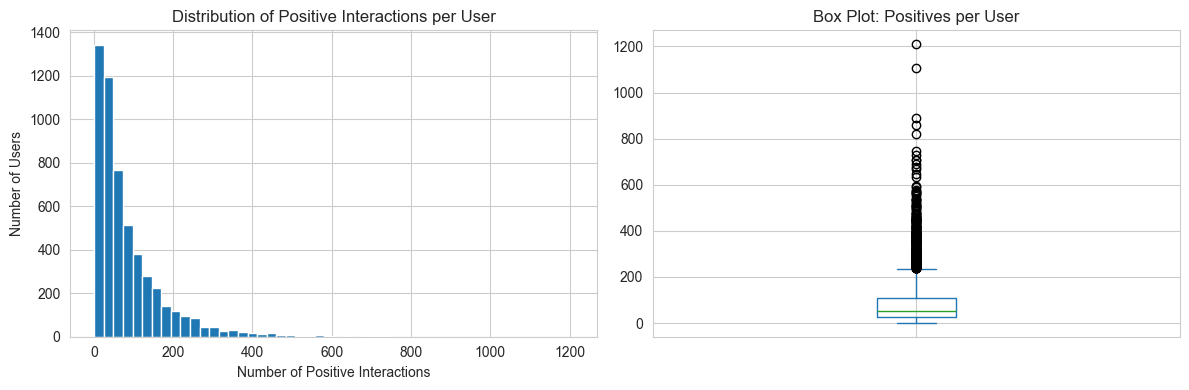

In [7]:
# Analyze positive interaction patterns
positives_per_user = train_positive.groupby('user_id').size()

print("Positive interactions per user (train):")
print(positives_per_user.describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
positives_per_user.hist(bins=50)
plt.title('Distribution of Positive Interactions per User')
plt.xlabel('Number of Positive Interactions')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
positives_per_user.plot(kind='box')
plt.title('Box Plot: Positives per User')
plt.tight_layout()
plt.show()

## 2. Build ID Mappings

PyTorch embedding layers require contiguous integer indices starting from 0.
We create bidirectional mappings:
- `user_id → internal_idx`
- `movie_id → internal_idx`

**Important**: We build mappings from ALL users and items in train data to ensure consistency.

In [8]:
def build_id_mappings(df: pd.DataFrame) -> Tuple[Dict[int, int], Dict[int, int]]:
    """
    Build bidirectional ID mappings from original IDs to contiguous indices.
    
    Args:
        df: DataFrame with 'user_id' and 'movie_id' columns
        
    Returns:
        (user_to_idx, item_to_idx) dictionaries
    """
    unique_users = sorted(df['user_id'].unique())
    unique_items = sorted(df['movie_id'].unique())
    
    user_to_idx = {uid: idx for idx, uid in enumerate(unique_users)}
    item_to_idx = {iid: idx for idx, iid in enumerate(unique_items)}
    
    return user_to_idx, item_to_idx

# Build mappings from training data
# Use ALL train ratings (not just positive) to include all users/items
user_to_idx, item_to_idx = build_id_mappings(train_ratings)

# Reverse mappings for retrieval
idx_to_user = {v: k for k, v in user_to_idx.items()}
idx_to_item = {v: k for k, v in item_to_idx.items()}

num_users = len(user_to_idx)
num_items = len(item_to_idx)

print(f"Number of users: {num_users:,}")
print(f"Number of items: {num_items:,}")

Number of users: 5,400
Number of items: 3,662


In [9]:
# Verify mappings are bijective
assert len(user_to_idx) == len(idx_to_user), "User mapping is not bijective!"
assert len(item_to_idx) == len(idx_to_item), "Item mapping is not bijective!"
assert set(user_to_idx.values()) == set(range(num_users)), "User indices not contiguous!"
assert set(item_to_idx.values()) == set(range(num_items)), "Item indices not contiguous!"

print("ID mappings verified: bijective and contiguous")

ID mappings verified: bijective and contiguous


## 3. Build User-Item Interaction Sets

For negative sampling, we need to know which items each user has interacted with.
This allows us to sample items the user has NOT seen as negatives.

In [10]:
def build_user_positive_items(df: pd.DataFrame, user_to_idx: Dict, item_to_idx: Dict) -> Dict[int, Set[int]]:
    """
    Build a dictionary mapping user index to set of positive item indices.
    
    Args:
        df: DataFrame with positive interactions
        user_to_idx: User ID to index mapping
        item_to_idx: Item ID to index mapping
        
    Returns:
        Dict mapping user_idx to set of positive item_idx
    """
    user_positive_items = defaultdict(set)
    
    for _, row in df.iterrows():
        user_idx = user_to_idx.get(row['user_id'])
        item_idx = item_to_idx.get(row['movie_id'])
        
        if user_idx is not None and item_idx is not None:
            user_positive_items[user_idx].add(item_idx)
    
    return dict(user_positive_items)

# Build interaction sets, where postive means user has rated item >= 4
train_user_positives = build_user_positive_items(train_positive, user_to_idx, item_to_idx)
val_user_positives = build_user_positive_items(val_positive, user_to_idx, item_to_idx)

print(f"Users with train positives: {len(train_user_positives):,}")
print(f"Users with val positives: {len(val_user_positives):,}")

Users with train positives: 5,396
Users with val positives: 490


<cell_type>markdown</cell_type>## 4. Alternative: Explicit Negative Sampling (Not Used)

**Note:** This section shows an alternative approach using explicit negative sampling.
We use **in-batch negatives** instead (see Section 5), which is more efficient and prevents overfitting.

This code is kept for educational purposes to show the difference between approaches.

In [ ]:
# NOTE: This NegativeSampler is NOT USED - we use in-batch negatives instead.
# Kept for educational purposes to show the alternative approach.

class NegativeSampler:
    """
    [NOT USED] Samples negative items for Two-Tower training.
    
    For each positive (user, item) pair, samples items the user
    has NOT interacted with as negative examples.
    
    Problem: Static negatives can lead to overfitting.
    Solution: Use in-batch negatives instead (see training loop).
    """
    
    def __init__(self, num_items: int, user_positive_items: Dict[int, Set[int]], num_negatives: int = 4):
        self.num_items = num_items
        self.all_items = set(range(num_items))
        self.user_positive_items = user_positive_items
        self.num_negatives = num_negatives
    
    def sample(self, user_idx: int) -> List[int]:
        positive_items = self.user_positive_items.get(user_idx, set())
        negative_candidates = list(self.all_items - positive_items)
        num_to_sample = min(self.num_negatives, len(negative_candidates))
        return list(np.random.choice(negative_candidates, size=num_to_sample, replace=False))

print("NegativeSampler defined (but not used - we use in-batch negatives)")

In [ ]:
# Skip this cell - NegativeSampler is not used
# Kept for reference only

print("Skipping NegativeSampler test - using in-batch negatives instead")

<cell_type>markdown</cell_type>## 5. PyTorch Dataset

Create a Dataset that returns (user, positive_item) tuples.

**Design choice**: In-batch negatives
- All other positive items in the batch serve as negatives
- With batch size 1024, each sample gets ~1023 negatives for free
- Dynamic negatives (different each batch) prevent overfitting
- Industry standard (YouTube, Google, Spotify)

In [ ]:
class TwoTowerDataset(Dataset):
    """
    PyTorch Dataset for Two-Tower model training with in-batch negatives.
    
    Each sample contains only:
    - user_idx: Internal user index
    - pos_item_idx: Positive item index
    
    Negatives come from other samples in the same batch during training.
    """
    
    def __init__(self, positive_df: pd.DataFrame, user_to_idx: Dict, item_to_idx: Dict):
        """
        Args:
            positive_df: DataFrame with positive interactions
            user_to_idx: User ID to index mapping
            item_to_idx: Item ID to index mapping
        """
        self.samples = []
        
        # Build samples (no negative sampling needed!)
        for _, row in tqdm(positive_df.iterrows(), total=len(positive_df), desc="Building dataset"):
            user_idx = user_to_idx.get(row['user_id'])
            item_idx = item_to_idx.get(row['movie_id'])
            
            if user_idx is not None and item_idx is not None:
                self.samples.append({
                    'user_idx': user_idx,
                    'pos_item_idx': item_idx
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            'user_idx': torch.tensor(sample['user_idx'], dtype=torch.long),
            'pos_item_idx': torch.tensor(sample['pos_item_idx'], dtype=torch.long)
        }

# Create training dataset (much faster now - no negative sampling!)
train_dataset = TwoTowerDataset(train_positive, user_to_idx, item_to_idx)
print(f"Training samples: {len(train_dataset):,}")

In [ ]:
# Test dataset
sample = train_dataset[0]
print("Sample structure:")
for k, v in sample.items():
    print(f"  {k}: shape={v.shape}, dtype={v.dtype}")

## 6. Two-Tower Model Architecture

The model consists of two independent towers:
- **User Tower**: Maps user_id → embedding
- **Item Tower**: Maps item_id → embedding

Both towers have the same architecture:
```
Embedding → Linear → BatchNorm → ReLU → Dropout
         → Linear → BatchNorm → ReLU → Dropout
         → Linear → L2 Normalize
```

**Why L2 normalize?**
- Enables cosine similarity via dot product
- Stable gradients (bounded outputs)
- Works well with FAISS inner product search

In [ ]:
class Tower(nn.Module):
    """
    Simple tower: just embedding + L2 normalize.
    
    No MLP - simpler model that's easier to optimize.
    """
    
    def __init__(self, num_entities: int, embedding_dim: int, hidden_dims: List[int] = None, dropout: float = 0.1):
        """
        Args:
            num_entities: Number of unique entities (users or items)
            embedding_dim: Embedding dimension
            hidden_dims: Ignored (kept for API compatibility)
            dropout: Ignored (kept for API compatibility)
        """
        super().__init__()
        
        # Just an embedding layer - no MLP
        self.embedding = nn.Embedding(num_entities, embedding_dim)
        
        # Initialize embeddings with smaller values for stability
        nn.init.normal_(self.embedding.weight, mean=0, std=0.1)
    
    def forward(self, ids: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            ids: Entity IDs [batch_size] or [batch_size, num_items]
            
        Returns:
            L2-normalized embeddings
        """
        x = self.embedding(ids)
        x = F.normalize(x, p=2, dim=-1)  # L2 normalize
        return x

In [ ]:
class TwoTowerModel(nn.Module):
    """
    Two-Tower model for candidate generation.
    
    Learns separate embeddings for users and items that can be
    compared via dot product (cosine similarity when L2 normalized).
    """
    
    def __init__(self, num_users: int, num_items: int, embedding_dim: int = 64,
                 hidden_dims: List[int] = [128, 64], dropout: float = 0.1):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        
        # User and item towers
        self.user_tower = Tower(num_users, embedding_dim, hidden_dims, dropout)
        self.item_tower = Tower(num_items, embedding_dim, hidden_dims, dropout)
    
    def get_user_embedding(self, user_ids: torch.Tensor) -> torch.Tensor:
        """Get user embeddings."""
        return self.user_tower(user_ids)
    
    def get_item_embedding(self, item_ids: torch.Tensor) -> torch.Tensor:
        """Get item embeddings."""
        return self.item_tower(item_ids)
    
    def forward(self, user_ids: torch.Tensor, pos_item_ids: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass for training with in-batch negatives.
        
        Args:
            user_ids: [batch_size]
            pos_item_ids: [batch_size]
            
        Returns:
            (user_emb, item_emb): Embeddings for computing in-batch loss
        """
        user_emb = self.get_user_embedding(user_ids)  # [B, D]
        item_emb = self.get_item_embedding(pos_item_ids)  # [B, D]
        
        return user_emb, item_emb

In [ ]:
# Model hyperparameters
EMBEDDING_DIM = 128  # Larger since no MLP
HIDDEN_DIMS = [128, 64]  # Ignored by simple Tower
DROPOUT = 0.1  # Ignored by simple Tower

# Create model
model = TwoTowerModel(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=EMBEDDING_DIM,
    hidden_dims=HIDDEN_DIMS,
    dropout=DROPOUT
).to(device)

# Print model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

In [ ]:
# Test forward pass
batch = train_dataset[0]
user_ids = batch['user_idx'].unsqueeze(0).to(device)
pos_items = batch['pos_item_idx'].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    user_emb, item_emb = model(user_ids, pos_items)

print(f"User embedding shape: {user_emb.shape}")
print(f"Item embedding shape: {item_emb.shape}")
print(f"Cosine similarity: {(user_emb * item_emb).sum().item():.4f}")

<cell_type>markdown</cell_type>## 7. Loss Function: In-Batch Softmax (InfoNCE)

With in-batch negatives, we compute all-pairs similarity within a batch:
- Each user's positive item is the "correct" class
- All other items in the batch are "negatives"
- Cross-entropy where target is the diagonal

**Why this works:**
- Batch size 1024 → 1023 negatives per sample (for free!)
- Different batches = different negatives (dynamic, prevents overfitting)
- Efficient: reuses embeddings already computed for positives

**Diagram:**
```
              Items in batch
           item_0  item_1  item_2  ...
user_0  [  POS     neg     neg    ... ]  ← user_0's positive is item_0
user_1  [  neg     POS     neg    ... ]  ← user_1's positive is item_1  
user_2  [  neg     neg     POS    ... ]  ← user_2's positive is item_2
...
```
Target: diagonal (index i for row i)

In [ ]:
def in_batch_softmax_loss(user_emb: torch.Tensor, item_emb: torch.Tensor,
                          temperature: float = 0.1) -> torch.Tensor:
    """
    In-batch softmax loss (InfoNCE with in-batch negatives).
    """
    scores = torch.matmul(user_emb, item_emb.T) / temperature
    labels = torch.arange(scores.shape[0], device=scores.device)
    return F.cross_entropy(scores, labels)


def bpr_loss(user_emb: torch.Tensor, pos_item_emb: torch.Tensor, 
             neg_item_emb: torch.Tensor) -> torch.Tensor:
    """
    Bayesian Personalized Ranking (BPR) loss.
    
    Much simpler than in-batch softmax:
    - For each (user, pos_item, neg_item) triplet
    - Maximize: score(user, pos) - score(user, neg)
    
    Args:
        user_emb: [batch_size, dim]
        pos_item_emb: [batch_size, dim]
        neg_item_emb: [batch_size, dim]
    
    Returns:
        Scalar loss
    """
    pos_scores = (user_emb * pos_item_emb).sum(dim=1)  # [batch_size]
    neg_scores = (user_emb * neg_item_emb).sum(dim=1)  # [batch_size]
    
    # BPR loss: -log(sigmoid(pos - neg))
    loss = -F.logsigmoid(pos_scores - neg_scores).mean()
    return loss


print("Loss functions defined: in_batch_softmax_loss, bpr_loss")

## 8. Training Loop

Simple training loop with:
- Adam optimizer
- Loss tracking
- Progress bar

In [ ]:
# Training hyperparameters
BATCH_SIZE = 1024  # Keep - good for in-batch negatives  
LEARNING_RATE = 1e-3  # Lower from 0.05 → 0.001 (ChatGPT recommendation)
NUM_EPOCHS = 30
TEMPERATURE = 0.1  # Add - required for in-batch softmax (standard for contrastive learning)
USE_BPR = False  # Switch to in-batch softmax (industry standard)
WEIGHT_DECAY = 1e-6  # Add L2 regularization on embeddings

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Optimizer - switch from Adagrad to Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Loss function: {'BPR' if USE_BPR else 'In-batch Softmax'}")
print(f"Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Temperature: {TEMPERATURE}")

In [ ]:
# Training loop with in-batch softmax
train_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    for batch in pbar:
        user_ids = batch['user_idx'].to(device)
        pos_items = batch['pos_item_idx'].to(device)
        
        optimizer.zero_grad()
        
        # In-batch softmax: all other items in batch serve as negatives (1023 negatives per sample)
        user_emb, item_emb = model(user_ids, pos_items)
        loss = in_batch_softmax_loss(user_emb, item_emb, TEMPERATURE)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}: Average loss = {avg_loss:.4f}")
    
    # Evaluate on validation set every 5 epochs
    if (epoch + 1) % 5 == 0 or (epoch + 1) == NUM_EPOCHS:
        val_metrics = compute_recall_at_k(
            model=model,
            user_positives=val_user_positives,
            num_items=num_items,
            k_values=[10, 50, 100],
            device=device
        )
        print(f"  Validation metrics:")
        for metric, value in val_metrics.items():
            print(f"    {metric}: {value:.4f}")

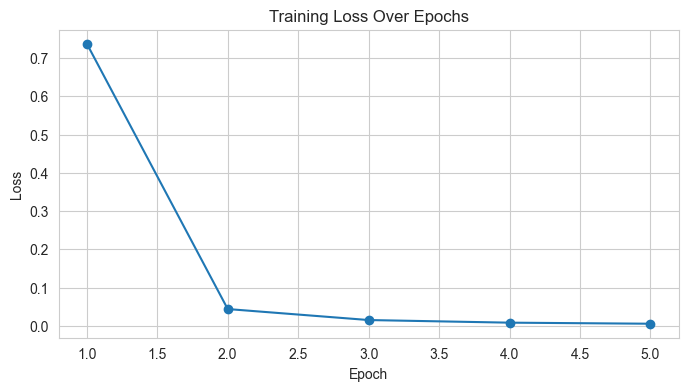

Loss is decreasing - model is learning!


In [22]:
# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

# Verify loss is decreasing
if train_losses[-1] < train_losses[0]:
    print("Loss is decreasing - model is learning!")
else:
    print("Warning: Loss not decreasing - check hyperparameters")

## 8.5 Embedding Quality Diagnostics

Verify that the model has learned to score positive items higher than random items.

This diagnostic helps identify if:
- Embeddings capture meaningful user-item relationships
- Training signal was strong enough
- Model is ready for deployment

In [ ]:
# Embedding diagnostics
model.eval()
with torch.no_grad():
    # Sample 100 random users
    sample_users = np.random.choice(list(train_user_positives.keys()), min(100, len(train_user_positives)), replace=False)
    
    diagnostics = []
    for user_idx in sample_users:
        # Get user embedding
        user_emb = model.get_user_embedding(torch.tensor([user_idx], device=device))
        
        # Get a positive item for this user
        if user_idx in train_user_positives:
            pos_items = list(train_user_positives[user_idx])
            if len(pos_items) > 0:
                pos_item_idx = pos_items[0]
                pos_item_emb = model.get_item_embedding(torch.tensor([pos_item_idx], device=device))
                
                # Random negative item
                neg_item_idx = np.random.randint(0, num_items)
                neg_item_emb = model.get_item_embedding(torch.tensor([neg_item_idx], device=device))
                
                # Compute scores
                pos_score = (user_emb * pos_item_emb).sum().item()
                neg_score = (user_emb * neg_item_emb).sum().item()
                
                diagnostics.append({
                    'pos_score': pos_score,
                    'neg_score': neg_score,
                    'diff': pos_score - neg_score
                })

# Analyze
diag_df = pd.DataFrame(diagnostics)
print("Embedding Quality Diagnostics:")
print(diag_df.describe())
print(f"\nPositive scores higher than negative: {(diag_df['diff'] > 0).sum() / len(diag_df) * 100:.1f}%")

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(diag_df['pos_score'], bins=30, alpha=0.5, label='Positive Items')
plt.hist(diag_df['neg_score'], bins=30, alpha=0.5, label='Random Items')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Score Distribution: Positive vs Random')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(diag_df['diff'], bins=30)
plt.xlabel('Score Difference (pos - neg)')
plt.ylabel('Count')
plt.title('Separation Between Positive and Random')
plt.axvline(0, color='red', linestyle='--', label='No separation')
plt.legend()
plt.tight_layout()
plt.show()

## 9. Evaluation: Recall@K

Recall@K measures: "Of items the user will engage with, what fraction did we retrieve in top-K?"

$$\text{Recall@K} = \frac{|\text{Retrieved}_K \cap \text{Relevant}|}{|\text{Relevant}|}$$

This is the primary metric for candidate generation.

In [23]:
def compute_recall_at_k(model: nn.Module, user_positives: Dict[int, Set[int]],
                        num_items: int, k_values: List[int] = [10, 50, 100],
                        device: str = 'cpu', max_users: int = None) -> Dict[str, float]:
    """
    Compute Recall@K for all users.
    
    Args:
        model: Trained TwoTowerModel
        user_positives: Dict mapping user_idx to positive item_idx set
        num_items: Total number of items
        k_values: List of K values to compute
        device: Computation device
        max_users: Maximum users to evaluate (for speed)
        
    Returns:
        Dict with recall@k for each k
    """
    model.eval()
    
    # Pre-compute all item embeddings
    with torch.no_grad():
        all_item_ids = torch.arange(num_items).to(device)
        item_embeddings = model.get_item_embedding(all_item_ids)  # [num_items, D]
    
    recalls = {f'recall@{k}': [] for k in k_values}
    users_to_eval = list(user_positives.keys())
    
    if max_users:
        users_to_eval = users_to_eval[:max_users]
    
    with torch.no_grad():
        for user_idx in tqdm(users_to_eval, desc="Computing Recall@K"):
            positive_items = user_positives[user_idx]
            if not positive_items:
                continue
            
            # Get user embedding
            user_tensor = torch.tensor([user_idx], device=device)
            user_emb = model.get_user_embedding(user_tensor)  # [1, D]
            
            # Compute similarity with all items
            scores = torch.matmul(user_emb, item_embeddings.T).squeeze()  # [num_items]
            
            # Get top-K
            max_k = max(k_values)
            top_k_indices = torch.topk(scores, max_k).indices.cpu().numpy()
            
            # Compute recall for each K
            for k in k_values:
                top_k_set = set(top_k_indices[:k])
                hits = len(top_k_set & positive_items)
                recall = hits / len(positive_items)
                recalls[f'recall@{k}'].append(recall)
    
    # Average across users
    return {k: np.mean(v) for k, v in recalls.items()}

In [ ]:
# Compute validation metrics
K_VALUES = [10, 50, 100]

val_metrics = compute_recall_at_k(
    model=model,
    user_positives=val_user_positives,
    num_items=num_items,
    k_values=K_VALUES,
    device=device
)

print("\nTwo-Tower Model Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ============================================
# BASELINE: Popularity-based recommender
# ============================================
# Recommend the most popular items to everyone
item_popularity = train_positive.groupby('movie_id').size().sort_values(ascending=False)
popular_item_ids = item_popularity.index.tolist()
popular_item_indices = [item_to_idx[iid] for iid in popular_item_ids if iid in item_to_idx]

# Compute popularity baseline recall
pop_recalls = {f'recall@{k}': [] for k in K_VALUES}
for user_idx, positive_items in val_user_positives.items():
    for k in K_VALUES:
        top_k_set = set(popular_item_indices[:k])
        hits = len(top_k_set & positive_items)
        recall = hits / len(positive_items)
        pop_recalls[f'recall@{k}'].append(recall)

print("\nPopularity Baseline Metrics:")
for k in K_VALUES:
    avg_recall = np.mean(pop_recalls[f'recall@{k}'])
    print(f"  recall@{k}: {avg_recall:.4f}")

# ============================================
# BASELINE: Random recommender
# ============================================
random_recalls = {f'recall@{k}': [] for k in K_VALUES}
for user_idx, positive_items in val_user_positives.items():
    random_items = set(np.random.choice(num_items, size=max(K_VALUES), replace=False))
    for k in K_VALUES:
        top_k_set = set(list(random_items)[:k])
        hits = len(top_k_set & positive_items)
        recall = hits / len(positive_items)
        random_recalls[f'recall@{k}'].append(recall)

print("\nRandom Baseline Metrics:")
for k in K_VALUES:
    avg_recall = np.mean(random_recalls[f'recall@{k}'])
    print(f"  recall@{k}: {avg_recall:.4f}")

## 10. FAISS Index

FAISS enables fast approximate nearest neighbor search.

For ~4K items, we use a **Flat index** (exact search):
- Fast enough for this scale
- No approximation error
- Simple to implement

For larger catalogs (100K+ items), use IVF or HNSW indexes.

In [ ]:
import faiss

# Materialize item embeddings
model.eval()
with torch.no_grad():
    all_item_ids = torch.arange(num_items).to(device)
    item_embeddings = model.get_item_embedding(all_item_ids).cpu().numpy()

print(f"Item embeddings shape: {item_embeddings.shape}")
print(f"Embedding dimension: {item_embeddings.shape[1]}")

In [ ]:
# Build FAISS index
# Using IndexFlatIP (Inner Product) since embeddings are L2 normalized
# Inner product of L2-normalized vectors = cosine similarity

embedding_dim = item_embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)

# Add item embeddings to index
index.add(item_embeddings.astype(np.float32))

print(f"Index built with {index.ntotal} items")

In [ ]:
# Test retrieval for a sample user
test_user_idx = 0

with torch.no_grad():
    user_tensor = torch.tensor([test_user_idx], device=device)
    user_emb = model.get_user_embedding(user_tensor).cpu().numpy().astype(np.float32)

# Search for top-10 items
k = 10
distances, indices = index.search(user_emb, k)

print(f"Top {k} items for user {test_user_idx}:")
for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
    original_movie_id = idx_to_item[idx]
    print(f"  {i+1}. Item {idx} (movie_id={original_movie_id}), score={dist:.4f}")

In [ ]:
# Verify FAISS retrieval matches brute-force
# This ensures our index is working correctly

with torch.no_grad():
    # Brute-force scores
    user_emb_torch = torch.tensor(user_emb, device=device)
    item_emb_torch = torch.tensor(item_embeddings, device=device)
    brute_force_scores = torch.matmul(user_emb_torch, item_emb_torch.T).squeeze()
    brute_force_top_k = torch.topk(brute_force_scores, k).indices.cpu().numpy()

# Compare
faiss_top_k = indices[0]
match = np.array_equal(brute_force_top_k, faiss_top_k)

print(f"Brute-force top-{k}: {brute_force_top_k}")
print(f"FAISS top-{k}:       {faiss_top_k}")
print(f"Match: {match}")

<cell_type>markdown</cell_type>## 11. Summary & Next Steps

**What we built in this notebook:**
1. Data pipeline: Explicit → implicit conversion, ID mappings
2. Two-Tower model: User/item towers with L2 normalization
3. Training: In-batch softmax loss (1023 negatives per sample)
4. Evaluation: Recall@K metrics
5. FAISS index: Fast retrieval

**Key design choices:**
- In-batch negatives: Industry standard, efficient, prevents overfitting to static negatives
- L2 normalized embeddings: Enables cosine similarity via dot product
- Large batch size: More negatives = better learning signal

**Next steps (productionization):**
1. Extract data pipeline to `candidate_gen/data/`
2. Extract model to `candidate_gen/model/`
3. Extract training to `candidate_gen/training/`
4. Extract retrieval to `candidate_gen/retrieval/`
5. Add early stopping based on validation Recall@K
6. Add MLflow experiment tracking
7. Add CLI entry points

In [ ]:
# Final summary
print("=" * 50)
print("CANDIDATE GENERATION EXPLORATION SUMMARY")
print("=" * 50)
print(f"\nData:")
print(f"  Users: {num_users:,}")
print(f"  Items: {num_items:,}")
print(f"  Train positives: {len(train_positive):,}")
print(f"  Positive threshold: rating >= {POSITIVE_THRESHOLD}")
print(f"\nModel:")
print(f"  Embedding dim: {EMBEDDING_DIM}")
print(f"  Hidden dims: {HIDDEN_DIMS}")
print(f"  Total params: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nTraining:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Temperature: {TEMPERATURE}")
print(f"  Negatives per sample: {BATCH_SIZE - 1} (in-batch)")
print(f"  Final loss: {train_losses[-1]:.4f}")
print(f"\nValidation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")
print(f"\nFAISS Index:")
print(f"  Type: Flat (exact)")
print(f"  Items indexed: {index.ntotal:,}")